# Wage ARIMA Model - Training (1997-2020), Training (2021-2023)

In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 2. Load the dataset
# URL of the Google Drive file
url = 'https://drive.google.com/uc?id=1wjTiPLhi938Ro-jfjVHF0d_YPvsLaRc3'

# Download the file
output = 'data_wage.csv'
gdown.download(url, output, quiet=False)

# Check the content of the downloaded file to ensure it's a valid CSV
with open(output, 'r') as file:
    content = file.read()
    print("File content preview:")
    print(content[:500]) 

# Load the CSV file into a pandas DataFrame
try:
    data = pd.read_csv(output, delimiter=',')  
    print(data.head())
except pd.errors.ParserError as e:
    print("Error parsing CSV file:", e)

Downloading...
From: https://drive.google.com/uc?id=1wjTiPLhi938Ro-jfjVHF0d_YPvsLaRc3
To: d:\OneDrive (Personal)\OneDrive\~ TMU 2023\CIND 820 - Big Data Analytics Project\06 - Initial Results & Code (10%)\data_wage.csv
100%|██████████| 80.1M/80.1M [00:01<00:00, 41.5MB/s]


File content preview:
ref_date,geo,wages,type_of_work,sex,age_group,value,occupation_classification,noc,sex_binary,age_group_numeric,geo_code,date_ordinal,year,month
1997-01-01,newfoundland and labrador,average hourly wage rate,full-time employees,males,25 to 54 years,18.7,legislative and senior management occupations,00,1,1,210,729025,1997,1
1997-02-01,newfoundland and labrador,average hourly wage rate,full-time employees,males,25 to 54 years,18.48,legislative and senior management occupations,00,1,1,210,729056,1997
     ref_date                        geo                     wages  \
0  1997-01-01  newfoundland and labrador  average hourly wage rate   
1  1997-02-01  newfoundland and labrador  average hourly wage rate   
2  1997-03-01  newfoundland and labrador  average hourly wage rate   
3  1997-04-01  newfoundland and labrador  average hourly wage rate   
4  1997-05-01  newfoundland and labrador  average hourly wage rate   

          type_of_work    sex       age_group  value  \


In [4]:
# 3. Preprocess Data
# Convert 'ref_date' to datetime
data['ref_date'] = pd.to_datetime(data['ref_date'], format='%Y-%m-%d')

# Set 'ref_date' as index
data.set_index('ref_date', inplace=True)

# Select the 'value' column for ARIMA modeling
wages = data['value']

In [5]:
# 4. Split Data into Training and Testing Sets
train_data = wages[wages.index < '2021-01-01']
test_data = wages[wages.index >= '2021-01-01']

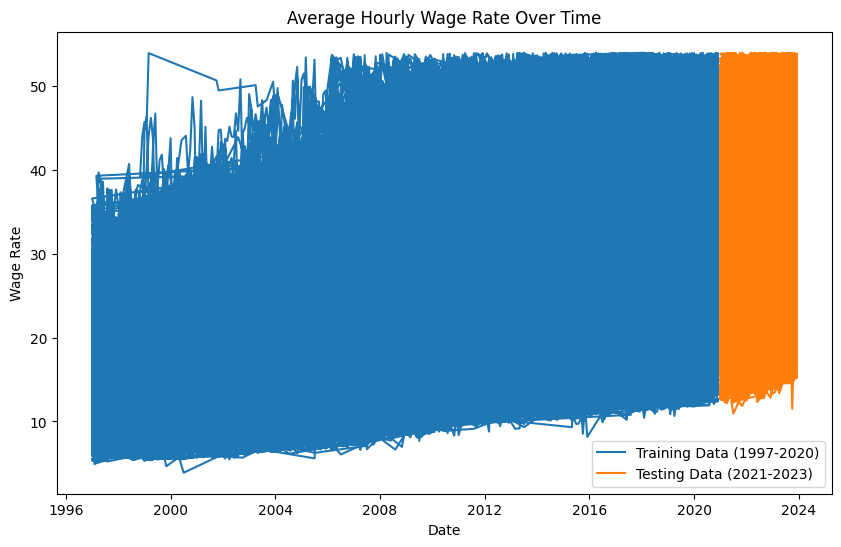

In [6]:
# 5. Visualize the Data
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data (1997-2020)')
plt.plot(test_data, label='Testing Data (2021-2023)')
plt.title('Average Hourly Wage Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Wage Rate')
plt.legend()
plt.show()

In [7]:
# 6. Stationarity Check
# Perform Augmented Dickey-Fuller test on training data
result = adfuller(train_data.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -28.74288061171748
p-value: 0.0


In [8]:
# 7. Fit the ARIMA Model
# Based on ACF and PACF plots, determine p, d, q (example: p=1, d=1, q=1)
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:               377087
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -902507.954
Date:                Thu, 04 Jul 2024   AIC                        1805021.907
Time:                        23:57:53   BIC                        1805054.428
Sample:                             0   HQIC                       1805031.223
                             - 377087                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6168      0.002    376.365      0.000       0.614       0.620
ma.L1         -0.8508      0.001   -674.058      0.000      -0.853      -0.848
sigma2         7.0207      0.005   1536.169      0.0

In [9]:
# 8. Forecasting
# Forecast the length of the test data
forecast = model_fit.forecast(steps=len(test_data))
forecast_index = test_data.index

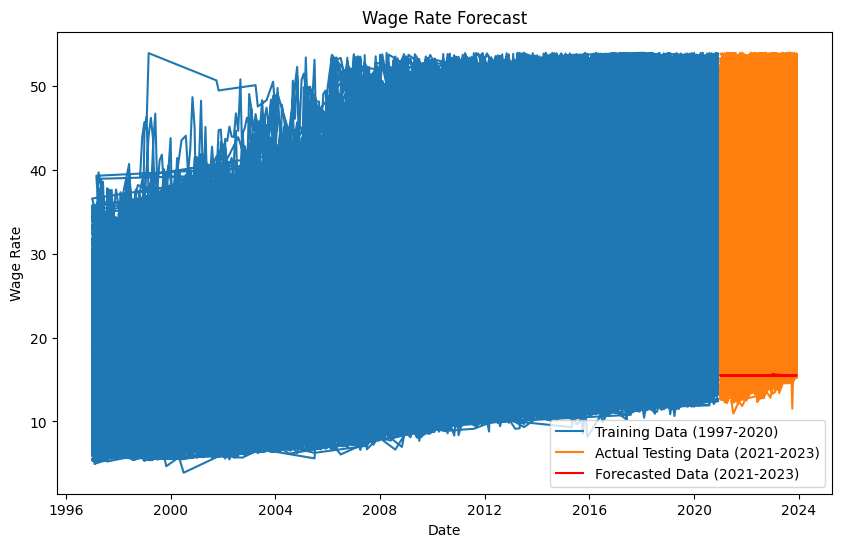

Mean Squared Error: 361.5058310000082


In [10]:
# 9. Evaluate the Model
# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data (1997-2020)')
plt.plot(test_data, label='Actual Testing Data (2021-2023)')
plt.plot(forecast_index, forecast, label='Forecasted Data (2021-2023)', color='red')
plt.title('Wage Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Wage Rate')
plt.legend()
plt.show()

# Calculate Mean Squared Error
mse = mean_squared_error(test_data, forecast)
print('Mean Squared Error:', mse)